In [830]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [831]:
asian_df_path = "~/ASR-PM2.5/datasets/intermediate_datasets/resultforasiandataset.csv"
asian_df = pd.read_csv(asian_df_path, dtype = {"FIPS": str}, index_col=0)

In [832]:
pm_df_path = "~/ASR-PM2.5/datasets/intermediate_datasets/resultforpm2.5dataset.csv"
pm_df = pd.read_csv(pm_df_path, dtype = {"FIPS": str}, index_col=0)

In [833]:
combined_large_data = asian_df.merge(pm_df, on = "FIPS")

In [834]:
combined_large_data

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght
0,06081,26,Pakistani alone (445),1017,8.628688
1,06081,47,Thai alone or in any combination (447-449) & (...,1116,8.628688
2,06081,32,Asian Indian alone or in any combination (400-...,18235,8.628688
3,06081,16,Chinese alone (410-419),76964,8.628688
4,06081,40,Indonesian alone or in any combination (423-42...,944,8.628688
...,...,...,...,...,...
5371,22101,29,Vietnamese alone (450-459),600,7.413572
5372,22101,48,Vietnamese alone or in any combination (450-45...,691,7.413572
5373,22045,43,Laotian alone or in any combination (442) & (1...,990,8.107645
5374,48057,35,Chinese alone or in any combination (410-419) ...,454,8.311283


In [835]:
combined_large_data["relative_weight"] = combined_large_data["estimated_pop"] * combined_large_data["pred_wght"]

In [836]:
combined_large_data["weighted_average"] = ""

In [837]:
combined_large_data

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average
0,06081,26,Pakistani alone (445),1017,8.628688,8775.375384,
1,06081,47,Thai alone or in any combination (447-449) & (...,1116,8.628688,9629.615465,
2,06081,32,Asian Indian alone or in any combination (400-...,18235,8.628688,157344.120083,
3,06081,16,Chinese alone (410-419),76964,8.628688,664098.319608,
4,06081,40,Indonesian alone or in any combination (423-42...,944,8.628688,8145.481182,
...,...,...,...,...,...,...,...
5371,22101,29,Vietnamese alone (450-459),600,7.413572,4448.143300,
5372,22101,48,Vietnamese alone or in any combination (450-45...,691,7.413572,5122.778367,
5373,22045,43,Laotian alone or in any combination (442) & (1...,990,8.107645,8026.568518,
5374,48057,35,Chinese alone or in any combination (410-419) ...,454,8.311283,3773.322515,


In [838]:
sorted_large_df = combined_large_data.sort_values("POPGROUP")

In [839]:
sorted_large_df["POPGROUP"]

3224    13
3572    13
2799    13
626     13
4670    13
        ..
2321    84
2870    84
2646    84
3267    84
1002    84
Name: POPGROUP, Length: 5376, dtype: int64

In [840]:
sorted_large_df["POPGROUP"].shift()

3224     NaN
3572    13.0
2799    13.0
626     13.0
4670    13.0
        ... 
2321    84.0
2870    84.0
2646    84.0
3267    84.0
1002    84.0
Name: POPGROUP, Length: 5376, dtype: float64

In [841]:
sorted_large_df["POPGROUP"].size

5376

In [842]:
sorted_large_df["POPGROUP"].ne(sorted_large_df["POPGROUP"].shift()).cumsum().size

5376

In [843]:
# shifts the popgroup down by 1 creating a list that increments by 1 for each popgroup after running the cumsum of ne

separate_subgroups = [value for index,value in sorted_large_df.groupby(sorted_large_df["POPGROUP"].ne(sorted_large_df["POPGROUP"].shift()).cumsum())]

In [844]:
separate_subgroups[0]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average
3224,13151,13,Asian Indian alone (400-401),2788,8.648723,24112.638746,
3572,13021,13,Asian Indian alone (400-401),1068,8.798820,9397.140237,
2799,36103,13,Asian Indian alone (400-401),16741,7.764497,129985.444170,
626,18003,13,Asian Indian alone (400-401),2266,10.129345,22953.095799,
4670,36055,13,Asian Indian alone (400-401),6210,8.250441,51235.239239,
...,...,...,...,...,...,...,...
1287,51087,13,Asian Indian alone (400-401),11335,7.737872,87708.776918,
2682,08001,13,Asian Indian alone (400-401),1403,6.601246,9261.548440,
5072,36111,13,Asian Indian alone (400-401),834,6.334383,5282.875425,
2039,13135,13,Asian Indian alone (400-401),20734,8.353870,173209.136225,


In [845]:
separate_subgroups

pre_calculation_datasets = separate_subgroups.copy()
pre_calculation_datasets.append(combined_large_data)


In [846]:
def calculations(dfs):
    def calculate_weighted_average(df):
        # calculate weighted average
        def is_unique(series):
            np_s = series.to_numpy()
            return np.all(np_s[0] == np_s)
        popgroups = df["POPGROUP"]
        popgroup_labels = df["POPGROUP_LABEL"]
        popgroup_num = popgroups.iloc[0] if is_unique(popgroups) else 0
        popgroup_label = popgroup_labels.iloc[0] if is_unique(popgroup_labels) else "Combined Asian American Subgroups"
        df.loc[df.shape[0]] = [None, popgroup_num, popgroup_label, df["estimated_pop"].sum(), None, df["relative_weight"].sum(), df["relative_weight"].sum() / df["estimated_pop"].sum()]
        # convert back to an int from float
        df.estimated_pop = df.estimated_pop.astype(int)
        df.POPGROUP = df.POPGROUP.astype(int)
    def calculate_std_dev(df):
#         df["std_dev_parts_and_actual"] = ((df["pred_wght"] - df.iloc[(len(df) - 1), 6]) ** 2) * df["estimated_pop"]
#         df["std_dev_parts_and_actual"] = df["std_dev_parts_and_actual"].fillna(np.sqrt(df["std_dev_parts_and_actual"].sum() / df.iloc[(len(df) - 1), 3]))
        df["std_dev_parts_and_actual"] = ((df["pred_wght"] - df["weighted_average"].iloc[(len(df["weighted_average"]) - 1)]) ** 2) * df["estimated_pop"]
        df["std_dev_parts_and_actual"] = df["std_dev_parts_and_actual"].fillna(np.sqrt(df["std_dev_parts_and_actual"].sum() / df["estimated_pop"].iloc[(len(df) - 1)]))
    for df in dfs:
        calculate_weighted_average(df)
        calculate_std_dev(df)
    
    return dfs

In [847]:
# for dataset in range(len(separate_subgroups)):
#     separate_subgroups[dataset].loc[separate_subgroups[dataset].shape[0]] = [None, 0, separate_subgroups[dataset]["estimated_pop"].sum(), None, separate_subgroups[dataset]["relative_weight"].sum(), separate_subgroups[dataset]["relative_weight"].sum() / separate_subgroups[dataset]["estimated_pop"].sum()]
#     separate_subgroups[dataset].estimated_pop = separate_subgroups[dataset].estimated_pop.astype(int)
#     separate_subgroups[dataset].POPGROUP = separate_subgroups[dataset].POPGROUP.astype(int)
#     separate_subgroups[dataset]["std_dev_parts_and_actual"] = ((separate_subgroups[dataset]["pred_wght"] - separate_subgroups[dataset].iloc[(len(separate_subgroups[dataset]) - 1), 5]) ** 2) * separate_subgroups[dataset]["estimated_pop"]
#     separate_subgroups[dataset]["std_dev_parts_and_actual"] = separate_subgroups[dataset]["std_dev_parts_and_actual"].fillna(np.sqrt(separate_subgroups[dataset]["std_dev_parts_and_actual"].sum() / separate_subgroups[dataset].iloc[(len(separate_subgroups[dataset]) - 1), 2]))

In [848]:
final_datasets = calculations(pre_calculation_datasets)
final_datasets[0]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average,std_dev_parts_and_actual
3224,13151,13,Asian Indian alone (400-401),2788,8.648723,2.411264e+04,,0.378452
3572,13021,13,Asian Indian alone (400-401),1068,8.79882,9.397140e+03,,20.470940
2799,36103,13,Asian Indian alone (400-401),16741,7.764497,1.299854e+05,,13436.239190
626,18003,13,Asian Indian alone (400-401),2266,10.129345,2.295310e+04,,4889.749736
4670,36055,13,Asian Indian alone (400-401),6210,8.250441,5.123524e+04,,1043.556971
...,...,...,...,...,...,...,...,...
2682,08001,13,Asian Indian alone (400-401),1403,6.601246,9.261548e+03,,5948.727467
5072,36111,13,Asian Indian alone (400-401),834,6.334383,5.282875e+03,,4512.133452
2039,13135,13,Asian Indian alone (400-401),20734,8.35387,1.732091e+05,,1947.846220
5064,41003,13,Asian Indian alone (400-401),763,6.738373,5.141378e+03,,2818.588842


In [849]:
final_datasets[42]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average,std_dev_parts_and_actual
0,06081,26,Pakistani alone (445),1017,8.628688,8.775375e+03,,0.033684
1,06081,47,Thai alone or in any combination (447-449) & (...,1116,8.628688,9.629615e+03,,0.036963
2,06081,32,Asian Indian alone or in any combination (400-...,18235,8.628688,1.573441e+05,,0.603962
3,06081,16,Chinese alone (410-419),76964,8.628688,6.640983e+05,,2.549125
4,06081,40,Indonesian alone or in any combination (423-42...,944,8.628688,8.145481e+03,,0.031266
...,...,...,...,...,...,...,...,...
5372,22101,48,Vietnamese alone or in any combination (450-45...,691,7.413572,5.122778e+03,,1029.952810
5373,22045,43,Laotian alone or in any combination (442) & (1...,990,8.107645,8.026569e+03,,274.740774
5374,48057,35,Chinese alone or in any combination (410-419) ...,454,8.311283,3.773323e+03,,47.412216
5375,55101,32,Asian Indian alone or in any combination (400-...,754,8.30557,6.262400e+03,,81.550553


In [850]:
len(final_datasets)

43

In [851]:
output_path = "~/ASR-PM2.5/datasets/output_datasets"

for index, dataset in enumerate(final_datasets):
    filepath = os.path.join(output_path, 'dataset_'+str(index)+'.csv')
    dataset.to_csv(filepath)

In [852]:
# zip(sorted_large_df.pred_wght, sorted_large_df.FIPS)

In [853]:
# dict(zip(sorted_large_df.pred_wght, sorted_large_df.FIPS))

In [854]:
num_fips = len(dict(zip(sorted_large_df.pred_wght, sorted_large_df.FIPS)))
num_fips

540

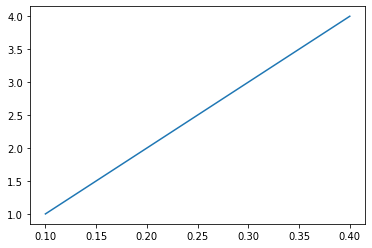

In [855]:
plt.plot([0.1, 0.2, 0.3, 0.4], [1, 2, 3, 4])
plt.show()

In [856]:
# separate_subgroups[40].name = "83"
# print (separate_subgroups[40].name)

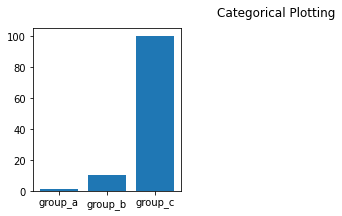

In [857]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

In [859]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("data_resolution")
from resolution_helpers import invalid_fips, remove_cols

weighted_avg_rows = []
for df in final_datasets:
    weighted_avg_rows.append(df.tail(1))

weighted_avg_df = pd.concat(weighted_avg_rows)
remove_cols(weighted_avg_df, ["POPGROUP_LABEL", "weighted_average", "std_dev_parts_and_actual"])

weighted_avg_df

,POPGROUP_LABEL,weighted_average,std_dev_parts_and_actual
358,Asian Indian alone (400-401),8.660374,1.267005
36,Bangladeshi alone (402),9.111202,0.803532
65,Cambodian alone (405-409),8.433241,1.721843
342,Chinese alone (410-419),8.702745,1.270707
338,Chinese (except Taiwanese) alone (410-411),8.701529,1.269940
44,Taiwanese alone (412-419),9.019614,1.100709
277,Filipino alone (420-421),8.619833,1.432897
54,Hmong alone (422),8.643111,1.819843
17,Indonesian alone (423-429),8.943701,1.276481
120,Japanese alone (430-439),8.676122,1.483452


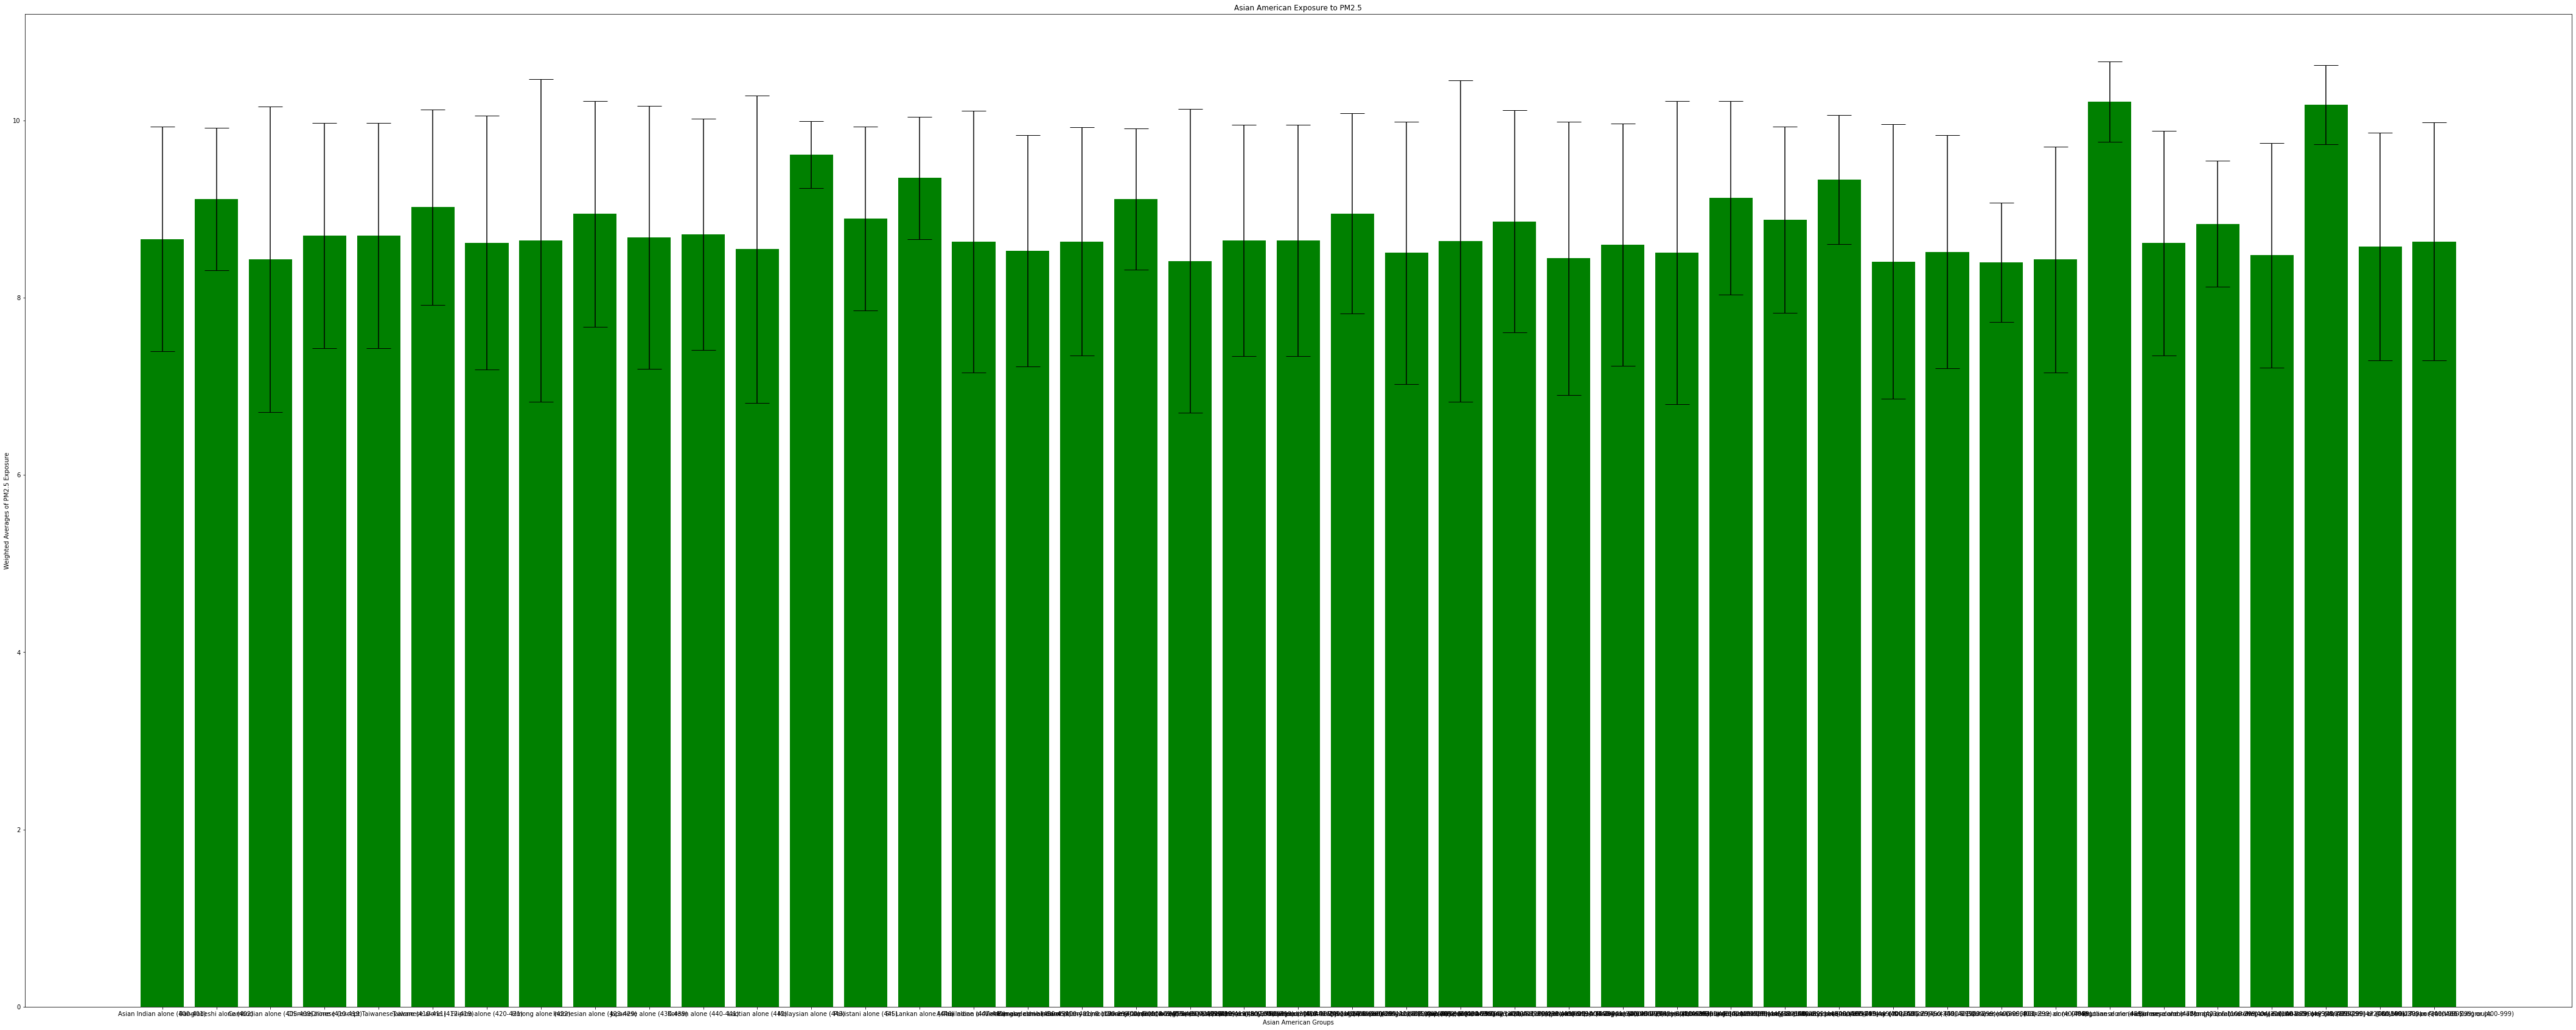

In [881]:
# Build the plot
popgroup_names = weighted_avg_df["POPGROUP_LABEL"].to_numpy()
weighted_avgs = weighted_avg_df["weighted_average"].to_numpy()
std_devs = weighted_avg_df["std_dev_parts_and_actual"].to_numpy()

x_pos = [i for i, _ in enumerate(popgroup_names)]


plt.figure(figsize=(75,30))
plt.bar(x_pos, weighted_avgs, color='green', yerr=std_devs, capsize=20)
plt.ylabel("Weighted Averages of PM2.5 Exposure")
plt.xlabel("Asian American Groups")
plt.title("Asian American Exposure to PM2.5")

plt.xticks(x_pos, popgroup_names)



plt.show()